### The problem is when I use the psd for OF, don't know if those psds are made physicsally correct

Saved: ../templates/noise_psd_white.npy
Saved: ../templates/noise_psd_pink.npy
Saved: ../templates/noise_psd_brownian.npy
Saved: ../templates/noise_psd_blue.npy
Saved: ../templates/noise_psd_violet.npy


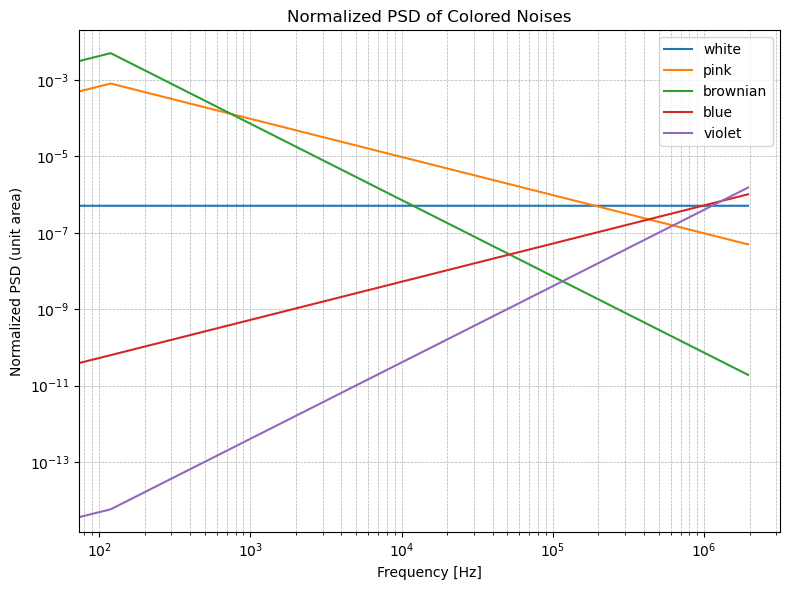

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import rfftfreq
from pathlib import Path

def compute_theoretical_psd(noise_type, noise_power, sampling_frequency, N, normalize_to_unit_area=False):
    frequencies = rfftfreq(N, d=1.0 / sampling_frequency)

    def _spectra(f):
        return {
            'white': np.ones_like(f),
            'blue': f,
            'violet': f**2,
            'brownian': 1. / np.where(f == 0, np.inf, f**2),
            'pink': 1. / np.where(f == 0, np.inf, f)
        }[noise_type]

    def _normalize(f):
        if noise_type == 'white':
            return 1. / (np.max(f) - np.min(f))
        elif noise_type == 'blue':
            return 2. / (np.max(f)**2 - np.min(f)**2)
        elif noise_type == 'violet':
            return 3. / (np.max(f)**3 - np.min(f)**3)
        elif noise_type == 'brownian':
            return 1. / (1. / np.sort(f)[1] - 1. / np.max(f))
        elif noise_type == 'pink':
            return 1. / (np.log(np.max(f)) - np.log(np.sort(f)[1]))
        else:
            raise ValueError(f"Unsupported noise type: {noise_type}")

    shape = _spectra(frequencies)
    norm_factor = 0.5 * noise_power * _normalize(frequencies) * sampling_frequency * N
    psd = norm_factor * shape

    if normalize_to_unit_area:
        area = np.trapz(psd, frequencies)
        psd /= area

    return frequencies, psd

# === Parameters ===
f_s = 3.90625e6
N = 32768
noise_power = 33.2
noise_types = ['white', 'pink', 'brownian', 'blue', 'violet']

# === Output directory ===
output_dir = Path("../templates")
output_dir.mkdir(parents=True, exist_ok=True)

# === Plotting and Saving ===
plt.figure(figsize=(8, 6))

for noise_type in noise_types:
    freqs, psd = compute_theoretical_psd(noise_type, noise_power, f_s, N, normalize_to_unit_area=True)
    
    # Plot
    plt.loglog(freqs, psd, label=noise_type)
    
    # Save to .npy
    save_path = output_dir / f"noise_psd_{noise_type}.npy"
    np.save(save_path, np.array(psd))
    print(f"Saved: {save_path}")

# === Finalize plot ===
plt.xlabel("Frequency [Hz]")
plt.ylabel("Normalized PSD (unit area)")
plt.title("Normalized PSD of Colored Noises")
plt.grid(True, which="both", ls="--", lw=0.5)
plt.legend()
plt.tight_layout()
plt.show()


In [5]:
from TraceSimulator import NoiseGenerator
import numpy as np
import yaml

yaml_str = """
LCE: '/ceph/bmaier/delight/share/TraceSimulator/optical/optSim_LCE.npz'
optArrivalTime: '/ceph/bmaier/delight/share/TraceSimulator/optical/optSim_arrivalTime.npz'
PCE: '/ceph/bmaier/delight/share/TraceSimulator/acoustic/phonSim_PCE.npz'
phonArrivalTime: '/ceph/bmaier/delight/share/TraceSimulator/acoustic/phonSim_phonTemplate.npz'
TCE: '/ceph/bmaier/delight/share/TraceSimulator/triplet/trSim_TCE.npz'
trArrivalTime: '/ceph/bmaier/delight/share/TraceSimulator/triplet/trSim_trTemplate.npz'
positionMMC: '/ceph/bmaier/delight/share/TraceSimulator/position_MMC.dat'
# from X-ray MMC analysis
sampling_frequency: 3906250
trace_samples: 32768
noise_type: 'pink'
noise_power: 33.2
"""

config = yaml.safe_load(yaml_str)
ng = NoiseGenerator(config)


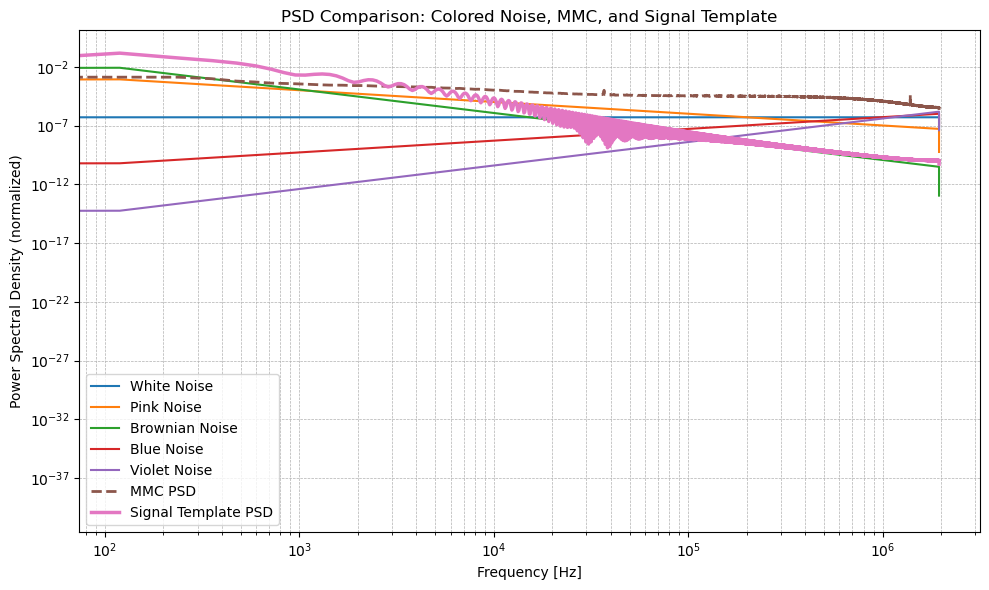

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from numpy.fft import rfft, rfftfreq
import os

# PSD calculator function (as defined before)
def calculate_psd(traces, sampling_frequency=1.0):
    norm = sampling_frequency * traces.shape[-1]
    if len(traces.shape) == 1:
        psd = (np.abs(rfft(traces)) ** 2.0) / norm
    else:
        psd = np.mean(np.abs(rfft(traces)) ** 2.0, axis=0) / norm

    psd[1:traces.shape[-1]//2 + 1 - (traces.shape[-1] + 1) % 2] *= 2.0
    f = rfftfreq(traces.shape[-1], d=1.0/sampling_frequency)
    return f, psd

# Your NoiseGenerator class (already defined in your message, assumed imported here)

# Configuration
sampling_rate = 3.90625e6
N = 32768
psd_area = 1.0  # arbitrary area for normalization

# Colors to compare
noise_types = ['white', 'pink', 'brownian', 'blue', 'violet']
color_psds = {}

# Generate PSDs for each color noise
for noise_type in noise_types:
    config = {
        'noise_type': noise_type,
        'noise_power': psd_area,
        'sampling_frequency': sampling_rate
    }
    ng = NoiseGenerator(config)
    trace = ng.generate_noise(N)
    f, psd = calculate_psd(trace, sampling_rate)
    color_psds[noise_type] = (f, psd)

# Load MMC PSD
frequencies = rfftfreq(N, d=1/sampling_rate)
mmc_path = "../templates/noise_psd_from_MMC.npy"
if os.path.exists(mmc_path):
    mmc_psd = np.load(mmc_path)
    if len(mmc_psd) != len(frequencies):
        original_freq = np.linspace(frequencies[0], frequencies[-1], len(mmc_psd))
        mmc_psd = interp1d(original_freq, mmc_psd, bounds_error=False, fill_value="extrapolate")(frequencies)
else:
    raise FileNotFoundError(f"MMC PSD not found at: {mmc_path}")

# Load signal template and compute PSD
template_path = "../templates/template_K_alpha_tight.npy"
if os.path.exists(template_path):
    signal = np.load(template_path)
    signal_freqs, signal_psd = calculate_psd(signal, sampling_frequency=sampling_rate)

    # Normalize signal PSD and interpolate to match plotting frequencies
    signal_psd /= np.max(signal_psd)
    signal_interp = interp1d(signal_freqs[1:], signal_psd[1:], bounds_error=False, fill_value=0)
    signal_psd_resampled = signal_interp(frequencies)
else:
    raise FileNotFoundError(f"Signal template not found at: {template_path}")

# Plot
plt.figure(figsize=(10, 6))
for name, (f, psd) in color_psds.items():
    plt.loglog(f, psd, label=f'{name.capitalize()} Noise')

plt.loglog(frequencies, mmc_psd, label='MMC PSD', linestyle='--', linewidth=2.0)
plt.loglog(frequencies, signal_psd_resampled, label='Signal Template PSD', linewidth=2.5)

plt.title("PSD Comparison: Colored Noise, MMC, and Signal Template")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Power Spectral Density (normalized)")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()


Generating white noise PSD...
  → Length of PSD: 16385
  ✔ Saved to ../templates/noise_psd_white.npy
Generating pink noise PSD...
  → Length of PSD: 16385
  ✔ Saved to ../templates/noise_psd_pink.npy
Generating brownian noise PSD...
  → Length of PSD: 16385
  ✔ Saved to ../templates/noise_psd_brownian.npy
Generating blue noise PSD...
  → Length of PSD: 16385
  ✔ Saved to ../templates/noise_psd_blue.npy
Generating violet noise PSD...
  → Length of PSD: 16385
  ✔ Saved to ../templates/noise_psd_violet.npy
MMC PSD loaded with matching length: 16385
  ✔ Saved MMC PSD as psd_mmc.npy
  ✔ Saved signal template PSD as psd_signal_template.npy


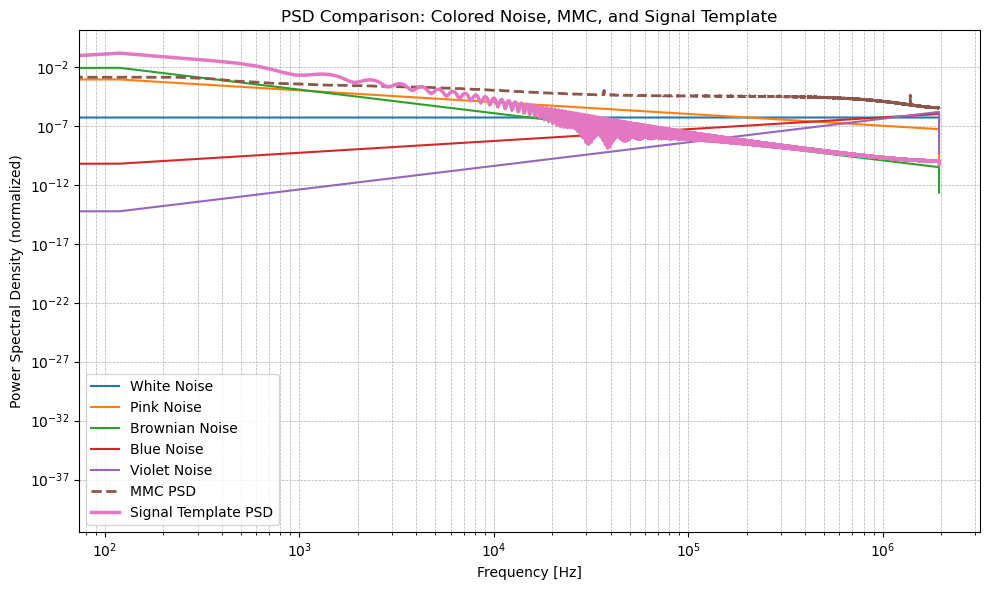

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from numpy.fft import rfft, rfftfreq
import os

# PSD calculator function
def calculate_psd(traces, sampling_frequency=1.0):
    norm = sampling_frequency * traces.shape[-1]
    if len(traces.shape) == 1:
        psd = (np.abs(rfft(traces)) ** 2.0) / norm
    else:
        psd = np.mean(np.abs(rfft(traces)) ** 2.0, axis=0) / norm

    psd[1:traces.shape[-1]//2 + 1 - (traces.shape[-1] + 1) % 2] *= 2.0
    f = rfftfreq(traces.shape[-1], d=1.0/sampling_frequency)
    return f, psd

# Configuration
sampling_rate = 3.90625e6
N = 32768
psd_area = 1.0
save_dir = "../templates"

# Colors to generate
noise_types = ['white', 'pink', 'brownian', 'blue', 'violet']
color_psds = {}

# Generate PSDs for each noise type
for noise_type in noise_types:
    print(f"Generating {noise_type} noise PSD...")
    
    config = {
        'noise_type': noise_type,
        'noise_power': psd_area,
        'sampling_frequency': sampling_rate
    }
    ng = NoiseGenerator(config)
    trace = ng.generate_noise(N)
    f, psd = calculate_psd(trace, sampling_rate)
    
    color_psds[noise_type] = (f, psd)
    
    print(f"  → Length of PSD: {len(psd)}")
    
    save_path = os.path.join(save_dir, f"noise_psd_{noise_type}.npy")
    np.save(save_path, psd)
    print(f"  ✔ Saved to {save_path}")

# Load MMC PSD
frequencies = rfftfreq(N, d=1/sampling_rate)
mmc_path = os.path.join(save_dir, "noise_psd_from_MMC.npy")
if os.path.exists(mmc_path):
    mmc_psd = np.load(mmc_path)
    if len(mmc_psd) != len(frequencies):
        original_freq = np.linspace(frequencies[0], frequencies[-1], len(mmc_psd))
        mmc_psd = interp1d(original_freq, mmc_psd, bounds_error=False, fill_value="extrapolate")(frequencies)
        print(f"  ↪ MMC PSD resampled to match FFT bins: {len(mmc_psd)}")
    else:
        print(f"MMC PSD loaded with matching length: {len(mmc_psd)}")
    
else:
    raise FileNotFoundError(f"MMC PSD not found at: {mmc_path}")

# Optional: Save signal PSD too, if needed
template_path = os.path.join(save_dir, "template_K_alpha_tight.npy")
if os.path.exists(template_path):
    signal = np.load(template_path)
    signal_freqs, signal_psd = calculate_psd(signal, sampling_frequency=sampling_rate)
    signal_psd /= np.max(signal_psd)
    signal_interp = interp1d(signal_freqs[1:], signal_psd[1:], bounds_error=False, fill_value=0)
    signal_psd_resampled = signal_interp(frequencies)
    np.save(os.path.join(save_dir, "psd_signal_template.npy"), signal_psd_resampled)
    print("  ✔ Saved signal template PSD as psd_signal_template.npy")
else:
    print("⚠️ Signal template not found; skipping signal PSD save.")

# Plot
plt.figure(figsize=(10, 6))
for name, (f, psd) in color_psds.items():
    plt.loglog(f, psd, label=f'{name.capitalize()} Noise')

plt.loglog(frequencies, mmc_psd, label='MMC PSD', linestyle='--', linewidth=2.0)
plt.loglog(frequencies, signal_psd_resampled, label='Signal Template PSD', linewidth=2.5)

plt.title("PSD Comparison: Colored Noise, MMC, and Signal Template")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Power Spectral Density (normalized)")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()



--- WHITE NOISE ---
L2 norm difference: 5.902e-07
Mean absolute error: 7.440e-11


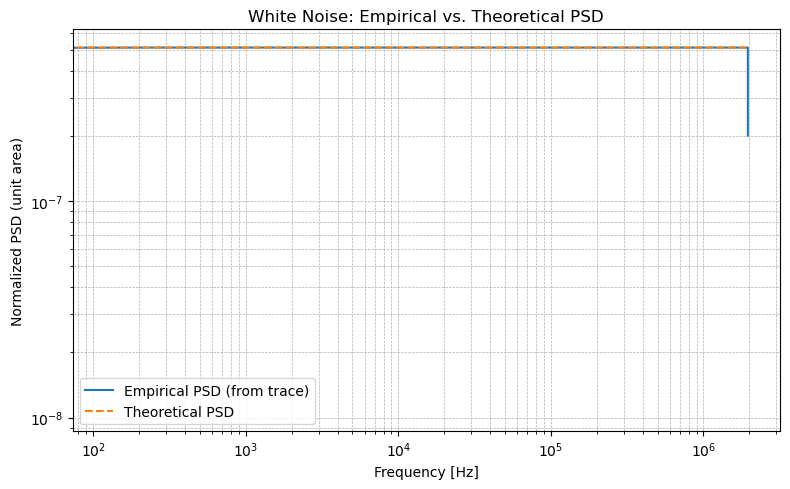


--- PINK NOISE ---
L2 norm difference: 4.979e-08
Mean absolute error: 4.549e-12


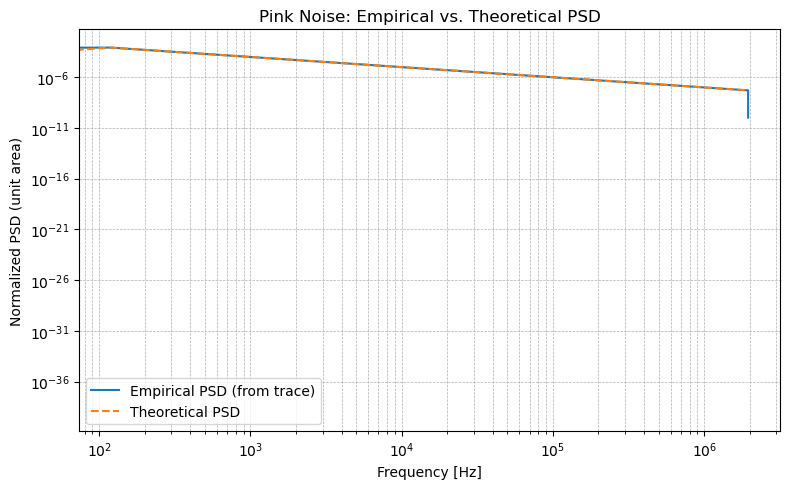


--- BROWNIAN NOISE ---
L2 norm difference: 1.715e-11
Mean absolute error: 1.497e-15


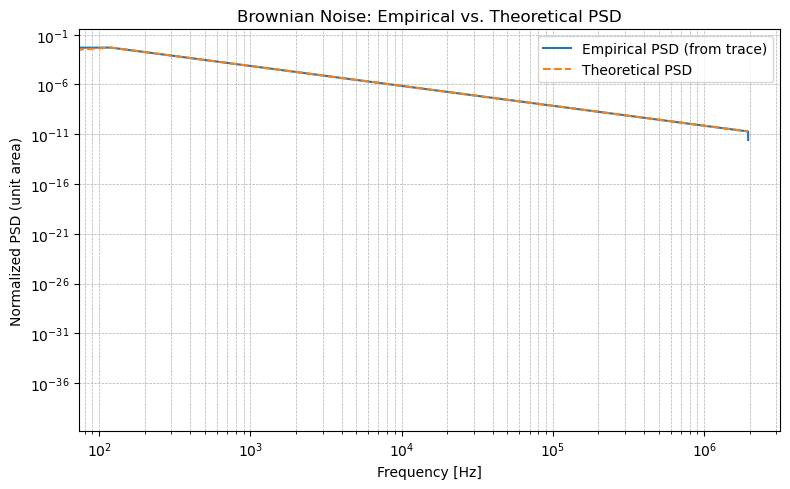


--- BLUE NOISE ---
L2 norm difference: 5.397e-07
Mean absolute error: 4.940e-11


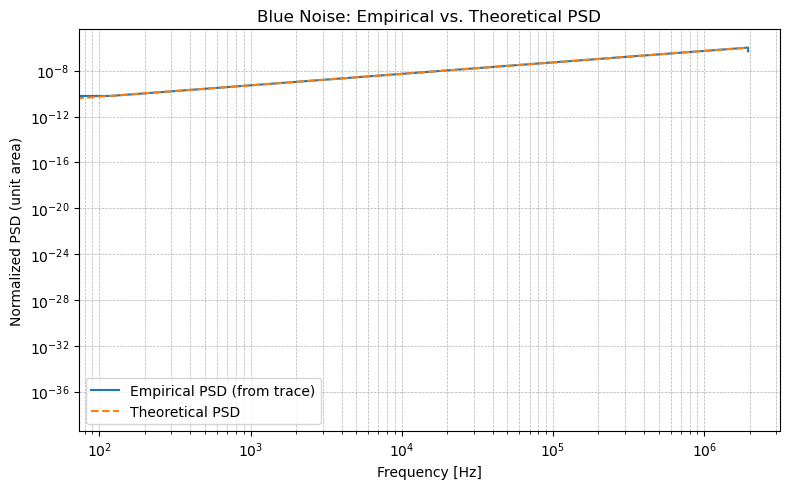


--- VIOLET NOISE ---
L2 norm difference: 1.315e-06
Mean absolute error: 1.204e-10


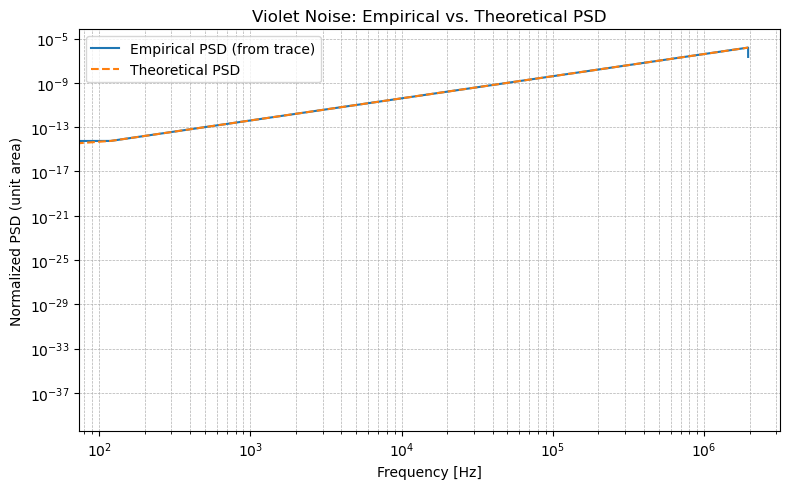

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import rfftfreq
from scipy.interpolate import interp1d
import os

# === PSD Computation from Trace ===
def calculate_psd(traces, sampling_frequency=1.0):
    norm = sampling_frequency * traces.shape[-1]
    if len(traces.shape) == 1:
        psd = (np.abs(np.fft.rfft(traces)) ** 2.0) / norm
    else:
        psd = np.mean(np.abs(np.fft.rfft(traces)) ** 2.0, axis=0) / norm

    psd[1:traces.shape[-1]//2 + 1 - (traces.shape[-1] + 1) % 2] *= 2.0
    f = rfftfreq(traces.shape[-1], d=1.0 / sampling_frequency)
    return f, psd

# === Theoretical PSD Generator ===
def compute_theoretical_psd(noise_type, noise_power, sampling_frequency, N, normalize_to_unit_area=False):
    frequencies = rfftfreq(N, d=1.0 / sampling_frequency)

    def _spectra(f):
        return {
            'white': np.ones_like(f),
            'blue': f,
            'violet': f**2,
            'brownian': 1. / np.where(f == 0, np.inf, f**2),
            'pink': 1. / np.where(f == 0, np.inf, f)
        }[noise_type]

    def _normalize(f):
        if noise_type == 'white':
            return 1. / (np.max(f) - np.min(f))
        elif noise_type == 'blue':
            return 2. / (np.max(f)**2 - np.min(f)**2)
        elif noise_type == 'violet':
            return 3. / (np.max(f)**3 - np.min(f)**3)
        elif noise_type == 'brownian':
            return 1. / (1. / np.sort(f)[1] - 1. / np.max(f))
        elif noise_type == 'pink':
            return 1. / (np.log(np.max(f)) - np.log(np.sort(f)[1]))
        else:
            raise ValueError(f"Unsupported noise type: {noise_type}")

    shape = _spectra(frequencies)
    norm_factor = 0.5 * noise_power * _normalize(frequencies) * sampling_frequency * N
    psd = norm_factor * shape

    if normalize_to_unit_area:
        area = np.trapz(psd, frequencies)
        psd /= area

    return frequencies, psd

# === Parameters ===
sampling_rate = 3.90625e6
N = 32768
noise_power = 1.0
noise_types = ['white', 'pink', 'brownian', 'blue', 'violet']

# === Compare Each Noise Type ===
for noise_type in noise_types:
    print(f"\n--- {noise_type.upper()} NOISE ---")

    # Theoretical PSD
    f_theory, psd_theory = compute_theoretical_psd(
        noise_type, noise_power, sampling_rate, N, normalize_to_unit_area=True)

    # Trace-based PSD
    config = {
        'noise_type': noise_type,
        'noise_power': noise_power,
        'sampling_frequency': sampling_rate
    }
    ng = NoiseGenerator(config)
    trace = ng.generate_noise(N)
    f_empirical, psd_empirical = calculate_psd(trace, sampling_rate)
    psd_empirical /= np.trapz(psd_empirical, f_empirical)  # Normalize to unit area

    # Interpolate theoretical to match empirical freq grid
    interp_theory = interp1d(f_theory, psd_theory, bounds_error=False, fill_value="extrapolate")
    psd_theory_resampled = interp_theory(f_empirical)

    # --- Numerical Comparison ---
    l2_norm = np.linalg.norm(psd_empirical - psd_theory_resampled)
    mae = np.mean(np.abs(psd_empirical - psd_theory_resampled))
    print(f"L2 norm difference: {l2_norm:.3e}")
    print(f"Mean absolute error: {mae:.3e}")

    # --- Plot ---
    plt.figure(figsize=(8, 5))
    plt.loglog(f_empirical, psd_empirical, label="Empirical PSD (from trace)")
    plt.loglog(f_empirical, psd_theory_resampled, label="Theoretical PSD", linestyle='--')
    plt.title(f"{noise_type.capitalize()} Noise: Empirical vs. Theoretical PSD")
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("Normalized PSD (unit area)")
    plt.legend()
    plt.grid(True, which="both", ls="--", lw=0.5)
    plt.tight_layout()
    plt.show()
